# Hybrid Quantum-Classical Model Exploration

## Overview

This notebook is inspired from https://opg.optica.org/viewmedia.cfm?r=1&rwjcode=opticaq&uri=opticaq-3-3-238&html=true and demonstrates a comparison between hybrid quantum-classical models and traditional linear models for image classification using the MNIST dataset. The implementation leverages the Merlin framework for quantum neural networks and PyTorch for classical neural networks.

## Key Components

### 1. Model Architectures

#### QuantumReservoir Model
The main hybrid architecture combines:
- A quantum layer processing PCA-reduced image features
- A linear classifier operating on the concatenation of the original flattened image and quantum output

#### Linear Model
A simple linear classifier operating directly on flattened image features, serving as a baseline for comparison.

#### PCA Model
A linear classifier operating on PCA-reduced features to evaluate the information content of the dimensionality reduction.

### 2. Data Preparation

- The MNIST dataset (Perceval Quest subset) is loaded using the custom `mnist_digits` module
- Images are flattened and normalized
- Principal Component Analysis (PCA) reduces feature dimensionality to a specified number of components



In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import merlin
from merlin import Ansatz
from merlin import PhotonicBackend as Experiment
from merlin import CircuitType
from merlin import AnsatzFactory
from merlin import QuantumLayer
from merlin import OutputMappingStrategy
from merlin import StatePattern

import perceval as pcvl  # just to display the circuit

In [2]:
# Simple Baseline Linear Model
class LinearModelBaseline(nn.Module):
    def __init__(self, image_size, num_classes=10):
        super(LinearModelBaseline, self).__init__()
        self.image_size = image_size

        # Classical part
        self.classifier = nn.Linear(image_size, num_classes)

    def forward(self, x):
        # Data is already flattened
        output = self.classifier(x)
        return output

In [3]:
# LinearModel with PCA
class LinearModelPCA(nn.Module):
    def __init__(self, image_size, pca_components, num_classes=10):
        super(LinearModelPCA, self).__init__()
        self.image_size = image_size
        self.pca_components = pca_components

        # Classical part
        self.classifier = nn.Linear(image_size + pca_components, num_classes)

    def forward(self, x, x_pca):
        # Data is already flattened, just concatenate
        combined_features = torch.cat((x, x_pca), dim=1)
        output = self.classifier(combined_features)
        return output

In [4]:
# definition of QuantumReservoir class - quantum layer applying on pca, and linear classifier on input and pca
class QuantumReservoir(nn.Module):
    def __init__(self, image_size, pca_components, n_modes, n_photons, num_classes=10):
        super(QuantumReservoir, self).__init__()
        self.image_size = image_size
        self.pca_components = pca_components
        self.n_modes = n_modes
        self.n_photons = n_photons

        # Quantum part (non-trainable reservoir)
        self.quantum_layer = self._create_quantum_reservoir(
            pca_components, n_modes, n_photons
        )

        # Classical part
        self.classifier = nn.Linear(
            image_size + self.quantum_layer.output_size,
            num_classes
        )

        print(f"\nQuantum Reservoir Created:")
        print(f"  Input size (PCA components): {pca_components}")
        print(f"  Quantum output size: {self.quantum_layer.output_size}")
        print(f"  Total features to classifier: {image_size + self.quantum_layer.output_size}")

    def _create_quantum_reservoir(self, input_size, n_modes, n_photons):
        """Create quantum layer with Series circuit in reservoir mode."""

        # Create experiment with Series circuit
        experiment = Experiment(
            circuit_type=CircuitType.SERIES,
            n_modes=n_modes,
            n_photons=n_photons,
            reservoir_mode=True,  # Non-trainable quantum layer
            use_bandwidth_tuning=False,  # No bandwidth tuning
            state_pattern=StatePattern.PERIODIC
        )

        # Create ansatz with automatic output size
        ansatz = AnsatzFactory.create(
            PhotonicBackend=experiment,
            input_size=input_size,
            # output_size not specified - will be calculated automatically
            output_mapping_strategy=OutputMappingStrategy.NONE
        )

        # Create quantum layer
        quantum_layer = QuantumLayer(
            input_size=input_size,
            ansatz=ansatz,
            shots=10000,  # Number of measurement shots
            no_bunching=False
        )

        return quantum_layer

    def forward(self, x, x_pca):
        # Process the PCA-reduced input through quantum layer
        quantum_output = self.quantum_layer(x_pca)

        # Concatenate original image features with quantum output
        combined_features = torch.cat((x, quantum_output), dim=1)

        # Final classification
        output = self.classifier(combined_features)
        return output


In [5]:
from merlin.datasets import mnist_digits

train_features, train_labels, train_metadata = mnist_digits.get_data_train_percevalquest()
test_features, test_labels, test_metadata = mnist_digits.get_data_test_percevalquest()

# Flatten the images from (N, 28, 28) to (N, 784)
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(train_features)
y_train = torch.LongTensor(train_labels)
X_test = torch.FloatTensor(test_features)
y_test = torch.LongTensor(test_labels)

print(f"Dataset loaded: {len(X_train)} training samples, {len(X_test)} test samples")


Dataset loaded: 6000 training samples, 600 test samples


In [6]:
n_components=8
M=9
N=4

In [7]:
# train PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)

# Note: Data is already flattened
X_train_flat = X_train
X_test_flat = X_test

pca.fit(X_train_flat)
X_train_pca = torch.FloatTensor(pca.transform(X_train_flat))
X_test_pca = torch.FloatTensor(pca.transform(X_test_flat))
print(X_train_pca)

tensor([[ 1.8300,  0.5721,  0.0553,  ..., -0.9327,  1.7091, -1.0749],
        [ 0.8860, -4.1798,  1.3963,  ...,  0.1214, -0.9330,  0.1368],
        [-0.2782,  1.7010,  0.4974,  ..., -0.4593, -1.0291,  1.7501],
        ...,
        [ 0.2924, -4.0464, -1.2219,  ..., -0.9095,  0.9783,  0.8630],
        [ 0.1567,  1.2983, -4.0294,  ..., -3.1340, -2.1575,  0.3926],
        [ 4.4576,  1.2257,  0.7489,  ..., -0.9504, -1.7016, -1.8599]])


In [8]:
# define corresponding linear model for comparison
linear_model = LinearModelBaseline(X_train_flat.shape[1])

In [9]:
# define model using pca featues
pca_model = LinearModelPCA(X_train_flat.shape[1], n_components)


Quantum Reservoir Created:
  Input size (PCA components): 8
  Quantum output size: 495
  Total features to classifier: 1279


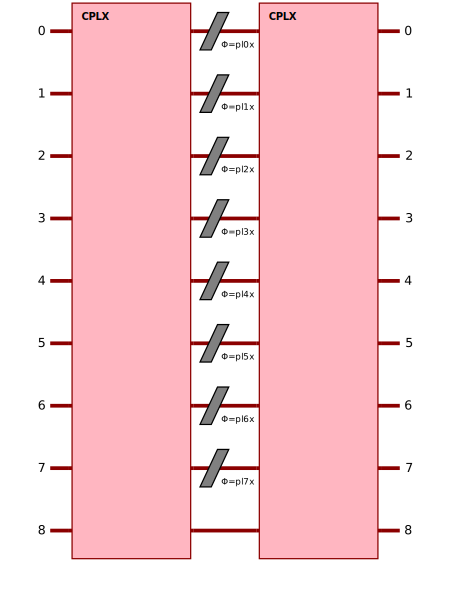

In [10]:
# define hybrid model
hybrid_model = QuantumReservoir(X_train_flat.shape[1], n_components, n_modes=M, n_photons=N)
pcvl.pdisplay(hybrid_model.quantum_layer.ansatz.circuit)

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.Adam(linear_model.parameters(), lr=0.001)
optimizer_pca = torch.optim.Adam(pca_model.parameters(), lr=0.001)
optimizer_hybrid = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)

# Create DataLoader for batching
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train, X_train_pca, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 25

history = {
      'hybrid': {'loss': [], 'accuracy': []},
      'pca': {'loss': [], 'accuracy': []},
      'linear': {'loss': [], 'accuracy': []},
      'epochs': []
}

for epoch in range(num_epochs):
    running_loss_hybrid = 0.0
    running_loss_linear = 0.0
    running_loss_pca = 0.0
    
    hybrid_model.train()
    linear_model.train()
    pca_model.train()
    
    for i, (images, pca_features, labels) in enumerate(train_loader):
        # Hybrid model - Forward and Backward pass
        outputs = hybrid_model(images, pca_features)
        loss = criterion(outputs, labels)
        optimizer_hybrid.zero_grad()
        loss.backward()
        optimizer_hybrid.step()
        running_loss_hybrid += loss.item()

        # Comparative linear model - Forward and Backward pass
        outputs = linear_model(images)
        loss = criterion(outputs, labels)
        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
        running_loss_linear += loss.item()

        # Comparative pca model - Forward and Backward pass
        outputs = pca_model(images, pca_features)
        loss = criterion(outputs, labels)
        optimizer_pca.zero_grad()
        loss.backward()
        optimizer_pca.step()
        running_loss_pca += loss.item()

    avg_loss_hybrid = running_loss_hybrid/len(train_loader)
    avg_loss_linear = running_loss_linear/len(train_loader)
    avg_loss_pca = running_loss_pca/len(train_loader)

    history['hybrid']['loss'].append(avg_loss_hybrid)
    history['linear']['loss'].append(avg_loss_linear)
    history['pca']['loss'].append(avg_loss_pca)

    history['epochs'].append(epoch + 1)

    hybrid_model.eval()
    linear_model.eval()
    pca_model.eval()
    with torch.no_grad():
        outputs = hybrid_model(X_test, X_test_pca)
        _, predicted = torch.max(outputs, 1)
        hybrid_accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        
        outputs = linear_model(X_test)
        _, predicted = torch.max(outputs, 1)
        linear_accuracy = (predicted == y_test).sum().item() / y_test.size(0)

        outputs = pca_model(X_test, X_test_pca)
        _, predicted = torch.max(outputs, 1)
        pca_accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        
    history['hybrid']['accuracy'].append(hybrid_accuracy)
    history['linear']['accuracy'].append(linear_accuracy)
    history['pca']['accuracy'].append(pca_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], LOSS -- Hybrid: {avg_loss_hybrid:.4f}, Linear: {avg_loss_linear:.4f}, PCA: {avg_loss_pca:.4f}'+
          f', ACCURACY -- Hybrid: {hybrid_accuracy:.4f}, Linear: {linear_accuracy:.4f}, PCA: {pca_accuracy:.4f}')

Epoch [1/25], LOSS -- Hybrid: 1.6186, Linear: 1.6428, PCA: 1.5413, ACCURACY -- Hybrid: 0.8067, Linear: 0.7933, PCA: 0.8100
Epoch [2/25], LOSS -- Hybrid: 0.9110, Linear: 0.9272, PCA: 0.8344, ACCURACY -- Hybrid: 0.8350, Linear: 0.8250, PCA: 0.8383
Epoch [3/25], LOSS -- Hybrid: 0.6787, Linear: 0.6900, PCA: 0.6258, ACCURACY -- Hybrid: 0.8500, Linear: 0.8567, PCA: 0.8583
Epoch [4/25], LOSS -- Hybrid: 0.5694, Linear: 0.5785, PCA: 0.5287, ACCURACY -- Hybrid: 0.8650, Linear: 0.8633, PCA: 0.8717
Epoch [5/25], LOSS -- Hybrid: 0.5032, Linear: 0.5112, PCA: 0.4697, ACCURACY -- Hybrid: 0.8783, Linear: 0.8750, PCA: 0.8750
Epoch [6/25], LOSS -- Hybrid: 0.4586, Linear: 0.4658, PCA: 0.4298, ACCURACY -- Hybrid: 0.8850, Linear: 0.8867, PCA: 0.8883
Epoch [7/25], LOSS -- Hybrid: 0.4252, Linear: 0.4318, PCA: 0.3999, ACCURACY -- Hybrid: 0.8917, Linear: 0.8833, PCA: 0.8933
Epoch [8/25], LOSS -- Hybrid: 0.3996, Linear: 0.4059, PCA: 0.3768, ACCURACY -- Hybrid: 0.8933, Linear: 0.8900, PCA: 0.8983
Epoch [9/25], LO

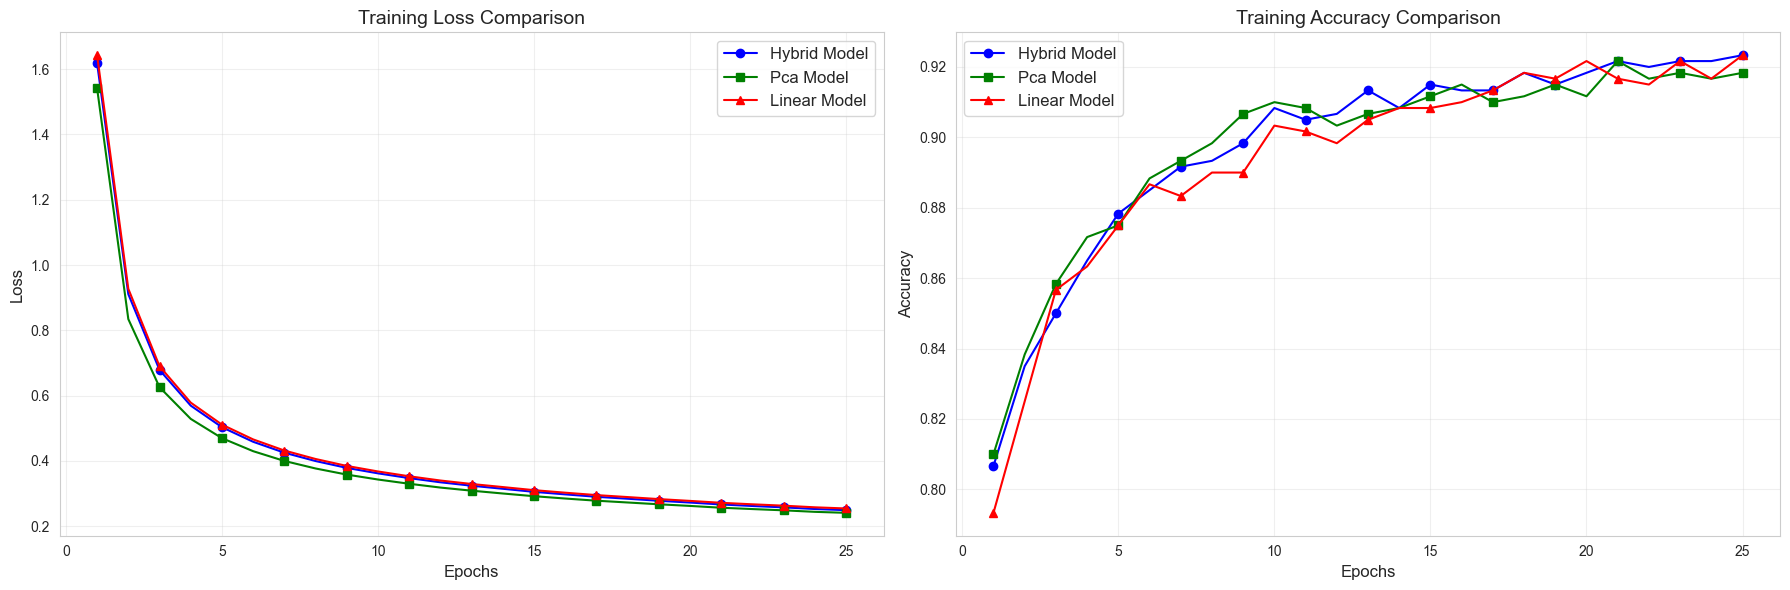

In [12]:
import matplotlib.pyplot as plt
def plot_training_comparison(history):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Define colors and styles for consistency
    model_styles = {
      'hybrid': {'color': 'blue', 'linestyle': '-', 'marker': 'o'},
      'pca': {'color': 'green', 'linestyle': '-', 'marker': 's'},
      'linear': {'color': 'red', 'linestyle': '-', 'marker': '^'}
    }

    # Plot loss curves
    for model_name, style in model_styles.items():
      if model_name in history:
          ax1.plot(
              history['epochs'],
              history[model_name]['loss'],
              color=style['color'],
              linestyle=style['linestyle'],
              marker=style['marker'],
              markevery=max(1, len(history['epochs'])//10),  # Show markers at 10 points
              label=f'{model_name.capitalize()} Model'
          )
    
    ax1.set_title('Training Loss Comparison', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot accuracy curves
    for model_name, style in model_styles.items():
      if model_name in history:
          ax2.plot(
              history['epochs'],
              history[model_name]['accuracy'],
              color=style['color'],
              linestyle=style['linestyle'],
              marker=style['marker'],
              markevery=max(1, len(history['epochs'])//10),  # Show markers at 10 points
              label=f'{model_name.capitalize()} Model'
          )
    
    ax2.set_title('Training Accuracy Comparison', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the function to generate the plot
plot_training_comparison(history)
